# Betting visualization and search for similar games
### Denisov Ilia

In [162]:
import numpy as np
import pylab as pl
import pandas as pd
%pylab inline
from datetime import datetime
from collections import Counter
import matplotlib.mlab as mlab
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import pairwise_distances
np.set_printoptions(precision=2, threshold=5)

Populating the interactive namespace from numpy and matplotlib


/home/denilv/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Preparing a dataset
Using Hamid Sardar's NCAA Basketball dataset for 2012-2017 seasons.

In [91]:
df_raw = pd.read_csv('seeds/inputs.csv')
df_raw = df_raw.fillna(0)
df = df_raw.iloc[::2]
df = df.reset_index()
delete_columns = ['week', 'game_id', 'season', 'index', 'team_org', 'opponent_team_org', 'win_against_spread']
df = df.drop(delete_columns, axis=1)

dates = np.array(df.date)
dates = [datetime.strptime(str(i), '%Y%m%d').date() for i in dates]
#add seasons
seasons = [i.year for i in dates]
#add weeknums
weeknums = [i.isocalendar()[1] for i in dates]
#add week day
weekdays = [i.weekday() for i in dates]
#add time
hours = []
for i in df.time:
    if i[-1] == 'p':
        hours.append(12+int(i.split(':')[0]))
    else:
        hours.append(int(i.split(':')[0]))
#add win/lose
winloses = [1 if i>0 else 0 for i in df.points_difference]

df.insert(1, 'winlose', winloses)
df.insert(1, 'hour', hours)
df.insert(1, 'weekday', weekdays)
df.insert(1, 'weeknum', weeknums)
df.insert(1, 'season', seasons)

df = df.drop(['date', 'time'], axis=1)
df.head()

,season,weeknum,weekday,hour,winlose,team,opponent_team,points,opponent_points,points_difference,spread,spread_percentage_sbr,moneyline_team,moneyline_opponent,total_team,total_opponent,spread_percentage_sportsplays,spread_percentage_vegas
0,2012,45,4,17,0,MSU,CONN,62,66,-4,-8.0,55,-355.0,320.0,133.0,133.0,75.0,69.0
1,2012,45,4,19,0,GAST,DUKE,55,74,-19,19.5,40,0.0,0.0,132.5,132.5,15.0,25.0
2,2012,45,4,21,0,LT,TXAM,59,71,-12,7.5,52,290.0,-350.0,133.0,133.0,22.0,76.0
3,2012,45,4,20,0,MD,UK,69,72,-3,10.5,61,485.0,-575.0,135.5,135.5,32.0,64.0
4,2012,45,4,23,0,INST,UCLA,59,86,-27,14.0,47,900.0,-1100.0,132.5,132.5,24.0,42.0


## Find of the most correlated features

In [92]:
def find_correlated_features(x, features):
    # replace this code to find really correlated features
    corr_matrix = abs(np.corrcoef(x.T))
    c = Counter()
    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            c['{} + {}'.format(feature_i, feature_j)] =  corr_matrix[i,j]
            if i < j and  corr_matrix[i,j] > 0.3:
                print("Correlated features: %s + %s -> %.2f" % (feature_i, feature_j, corr_matrix[i,j]))
#     print(c.most_common(20))

In [96]:
df.columns

Index(['season', 'weeknum', 'weekday', 'hour', 'winlose', 'team',
       'opponent_team', 'points', 'opponent_points', 'points_difference',
       'spread', 'spread_percentage_sbr', 'moneyline_team',
       'moneyline_opponent', 'total_team', 'total_opponent',
       'spread_percentage_sportsplays', 'spread_percentage_vegas'],
      dtype='object')

In [167]:
#['season', 'weeknum', 'weekday', 'hour', 'winlose',\
features = ['points', 'opponent_points', 'points_difference',\
       'spread', 'spread_percentage_sbr', 'moneyline_team',\
       'moneyline_opponent', 'total_team', 'total_opponent',\
       'spread_percentage_sportsplays', 'spread_percentage_vegas']
x = df[features].values

In [168]:
find_correlated_features(x, features)

Correlated features: points + opponent_points -> 0.42
Correlated features: points + points_difference -> 0.52
Correlated features: points + spread -> 0.31
Correlated features: points + total_team -> 0.41
Correlated features: points + total_opponent -> 0.41
Correlated features: opponent_points + points_difference -> 0.55
Correlated features: opponent_points + spread -> 0.34
Correlated features: opponent_points + total_team -> 0.44
Correlated features: opponent_points + total_opponent -> 0.44
Correlated features: points_difference + spread -> 0.61
Correlated features: points_difference + moneyline_team -> 0.37
Correlated features: points_difference + moneyline_opponent -> 0.30
Correlated features: points_difference + spread_percentage_sportsplays -> 0.33
Correlated features: spread + spread_percentage_sbr -> 0.36
Correlated features: spread + moneyline_team -> 0.57
Correlated features: spread + moneyline_opponent -> 0.46
Correlated features: spread + spread_percentage_sportsplays -> 0.55

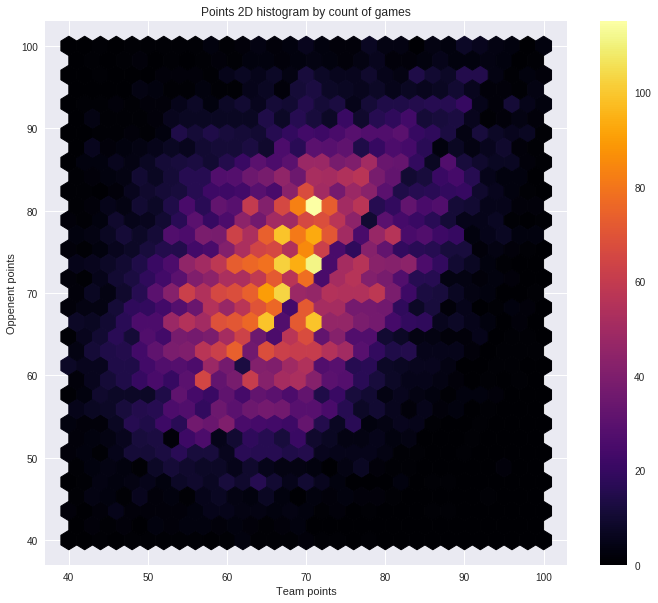

In [236]:
pl.figure(figsize=[11.7,10])
hb = pl.hexbin(df['points'], df['opponent_points'], gridsize=30, cmap='inferno', extent=[40, 100, 40, 100])
pl.xlabel('Team points')
pl.ylabel('Oppenent points')
pl.title('Points 2D histogram by count of games')
pl.colorbar()
pl.show()

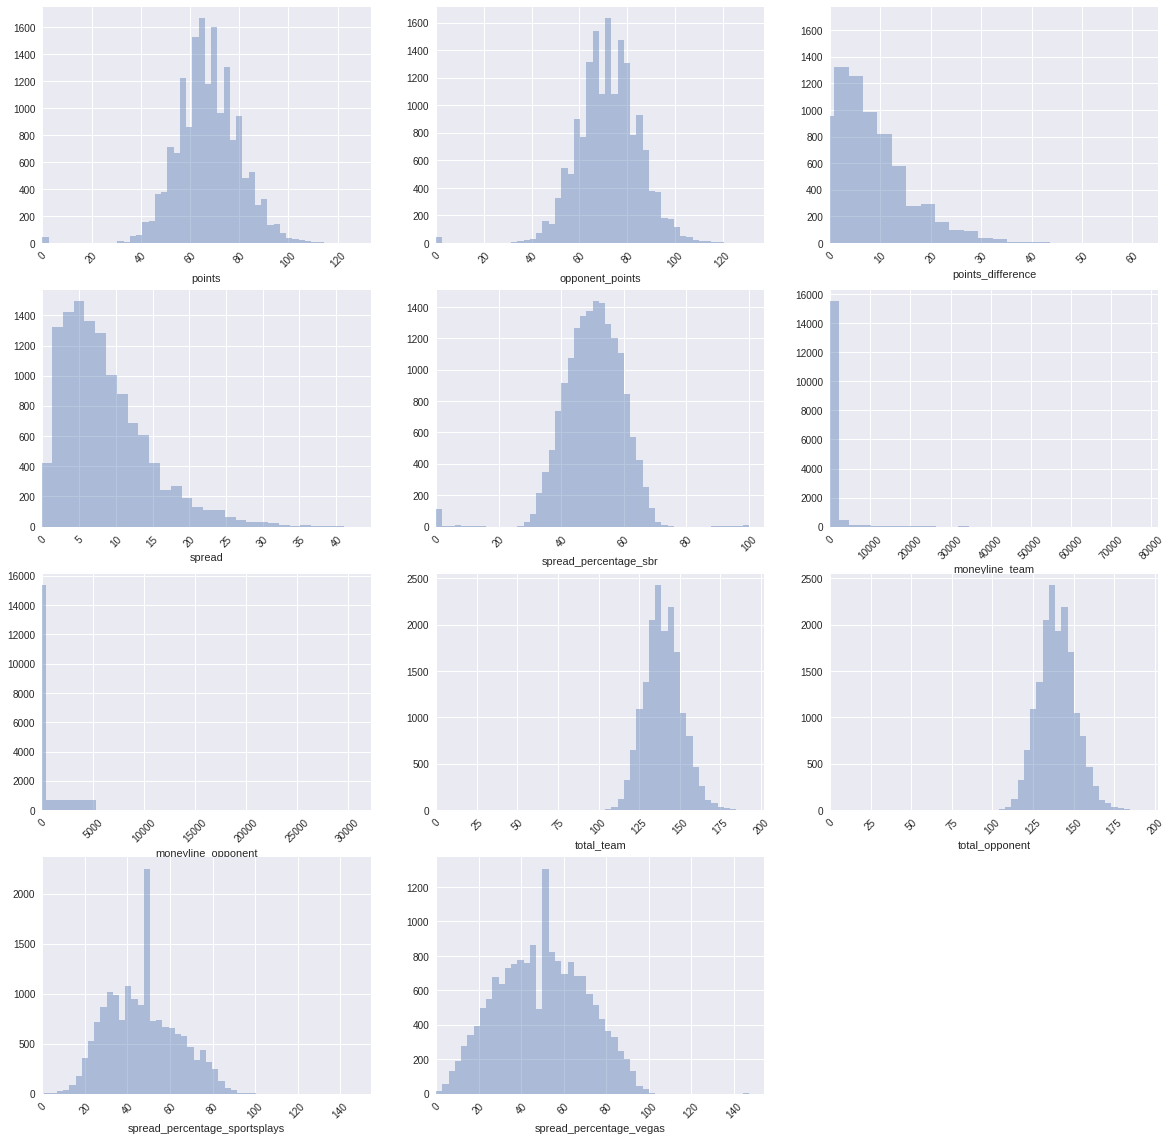

In [10]:
for i, f in enumerate(features):
    plt.subplot(4, 3,i+1)
    fig = plt.gcf()
    fig.set_size_inches(20,20)
    sns.distplot(df[f], kde=False)
    plt.xlim(0)
    plt.xticks(rotation=45)
plt.show()

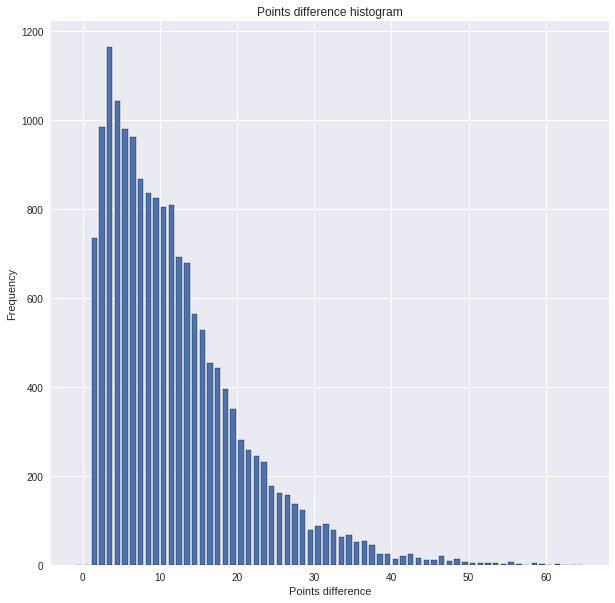

In [7]:
pts_diff = np.array(df['points_difference'])
pts_diff = np.abs(pts_diff)[pts_diff!=0]
pl.figure(figsize=[10,10])
n, bins, patches = pl.hist(pts_diff, bins=66, edgecolor='black', range=(-1, 65), rwidth=0.7)
pl.title('Points difference histogram')
pl.xlabel('Points difference')
pl.ylabel('Frequency')
# pl.xticks(range(-70,70,2))
pl.grid(True)
pl.show()

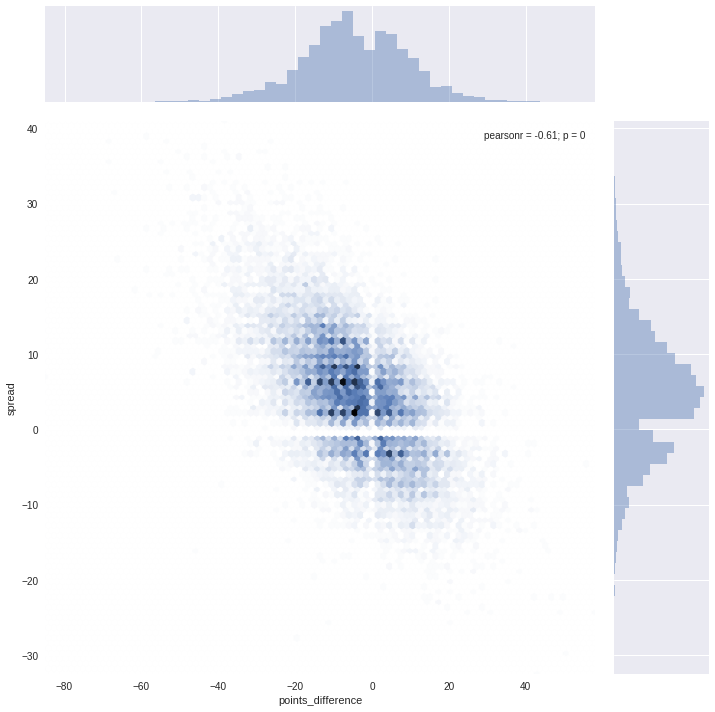

In [226]:
x = df.points_difference
y = df.spread
sns.jointplot(x=x, y=y, kind='hex', size=10)
pl.show()

# Get most similiar games

In [197]:
distance_features = ['points', 'opponent_points', 'points_difference',\
       'spread', 'spread_percentage_sbr', 'moneyline_team',\
       'moneyline_opponent', 'total_team', 'total_opponent',\
       'spread_percentage_sportsplays', 'spread_percentage_vegas']

Get top 10 closest games to given game by all distance_features (using Eucleadean metric).

In [198]:
def get_similar_games(games, top=10):
    dists = pairwise_distances(games)
    result = []
    for d in dists:
        args = d.argsort()
        similar_games = df.iloc[args[:top]]
        similar_games.insert(0, 'distance', d[args[:top]])
        result.append(similar_games)
    return result

In [199]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(np.array(df[distance_features].values))
similar_games = get_similar_games(scaled_features)

The first game is a game with a minimum distance of 0, i.e. the game itself, for which we are looking for similar games.

First selected game of 2017 NCAA Basketball season.

In [200]:
similar_games[16500]

,distance,season,weeknum,weekday,hour,winlose,team,opponent_team,points,opponent_points,points_difference,spread,spread_percentage_sbr,moneyline_team,moneyline_opponent,total_team,total_opponent,spread_percentage_sportsplays,spread_percentage_vegas
16500,0.000000,2017,8,6,14,0,UIC,WRST,49,87,-38,7.5,59,280.0,-310.0,155.0,155.0,34.0,51.0
13574,0.090084,2016,46,5,21,0,IDST,USU,51,85,-34,11.5,55,600.0,-750.0,154.5,154.5,34.0,44.0
15330,0.106794,2017,3,6,14,0,LAS,VCU,52,90,-38,7.5,62,265.0,-325.0,152.5,152.5,47.0,46.0
13379,0.120229,2016,45,6,20,0,LBSU,WICH,55,92,-37,10.5,58,500.0,-600.0,144.0,144.0,38.0,57.0
11708,0.126391,2016,4,5,19,0,WSU,UCLA,50,83,-33,10.0,49,425.0,-550.0,159.0,159.0,28.0,50.0
2332,0.137208,2013,9,5,20,0,UTM,PEAY,58,91,-33,5.5,49,190.0,-210.0,152.0,152.0,37.0,51.0
13120,0.139165,2016,10,4,19,0,ND,UNC,47,78,-31,7.5,50,285.0,-345.0,159.0,159.0,41.0,55.0
4859,0.141175,2014,5,3,19,0,CIT,GASO,52,83,-31,9.5,51,425.0,-485.0,142.5,142.5,37.0,50.0
11420,0.144739,2016,3,5,24,0,NW,IND,57,89,-32,10.0,52,425.0,-550.0,143.0,143.0,34.0,56.0
10109,0.148959,2015,49,4,19,0,MAN,SIE,54,89,-35,8.5,49,380.0,-430.0,149.0,149.0,39.0,63.0


Second selected game of 2017 NCAA Basketball season.

In [201]:
similar_games[16600]

,distance,season,weeknum,weekday,hour,winlose,team,opponent_team,points,opponent_points,points_difference,spread,spread_percentage_sbr,moneyline_team,moneyline_opponent,total_team,total_opponent,spread_percentage_sportsplays,spread_percentage_vegas
16600,0.000000,2017,9,3,20,1,CHAR,UTSA,76,75,1,1.5,44,115.0,-125.0,150.0,150.0,35.0,26.0
444,0.066143,2013,1,2,21,1,HALL,DEP,73,72,1,2.5,39,130.0,-140.0,150.0,150.0,32.0,28.0
11943,0.072032,2016,5,5,18,1,TOWS,ELON,81,77,4,3.5,41,145.0,-165.0,145.5,145.5,36.0,24.0
16281,0.074736,2017,8,0,20,1,CCAR,USA,81,77,4,2.5,45,133.0,-143.0,143.5,143.5,31.0,27.0
5759,0.074898,2014,9,3,22,0,CSN,CSF,81,82,-1,3.5,45,145.0,-165.0,148.5,148.5,36.0,26.0
12354,0.076059,2016,7,3,22,1,UTAH,UCLA,75,73,2,1.5,39,105.0,-125.0,147.0,147.0,37.0,33.0
1657,0.076587,2013,6,6,14,1,CAN,NIAG,77,70,7,4.5,43,180.0,-195.0,148.0,148.0,33.0,29.0
15705,0.077179,2017,5,5,24,1,PUR,MD,73,72,1,-1.5,47,-125.0,105.0,148.0,148.0,32.0,20.0
13002,0.077678,2016,10,1,24,0,WAKE,NCST,72,75,-3,3.0,45,135.0,-155.0,150.0,150.0,27.0,30.0
12033,0.077928,2016,6,1,19,1,TOL,BUFF,71,69,2,2.0,44,113.0,-133.0,150.0,150.0,30.0,21.0


Third selected game of 2017 NCAA Basketball season.

In [217]:
similar_games[16450]

,distance,season,weeknum,weekday,hour,winlose,team,opponent_team,points,opponent_points,points_difference,spread,spread_percentage_sbr,moneyline_team,moneyline_opponent,total_team,total_opponent,spread_percentage_sportsplays,spread_percentage_vegas
16450,0.000000,2017,8,5,18,0,KSU,OKLA,51,81,-30,-1.5,58,-125.0,105.0,138.5,138.5,67.0,62.0
9418,0.089044,2015,12,4,18,0,DAV,IOWA,52,83,-31,2.5,57,125.0,-145.0,145.5,145.5,61.0,60.0
9416,0.089044,2015,12,4,18,0,DAV,IOWA,52,83,-31,2.5,57,125.0,-145.0,145.5,145.5,61.0,60.0
9417,0.089044,2015,12,4,18,0,DAV,IOWA,52,83,-31,2.5,57,125.0,-145.0,145.5,145.5,61.0,60.0
1261,0.092288,2013,5,2,23,0,ORE,STAN,52,76,-24,3.0,55,130.0,-140.0,140.0,140.0,66.0,65.0
15850,0.101184,2017,6,1,21,0,MSU,MICH,57,86,-29,4.0,58,160.0,-185.0,135.0,135.0,65.0,61.0
15783,0.104050,2017,5,5,16,0,ARIZ,ORE,58,85,-27,4.0,58,165.0,-190.0,139.0,139.0,63.0,63.0
9351,0.107027,2015,12,1,20,0,ILL,ALA,58,79,-21,1.5,61,110.0,-120.0,135.5,135.5,63.0,65.0
6060,0.107125,2014,10,5,16,0,ARK,ALA,58,83,-25,-1.0,57,-112.0,102.0,141.5,141.5,71.0,73.0
1544,0.108088,2013,6,5,24,0,FSU,WAKE,46,71,-25,-3.0,55,-145.0,135.0,139.5,139.5,68.0,68.0


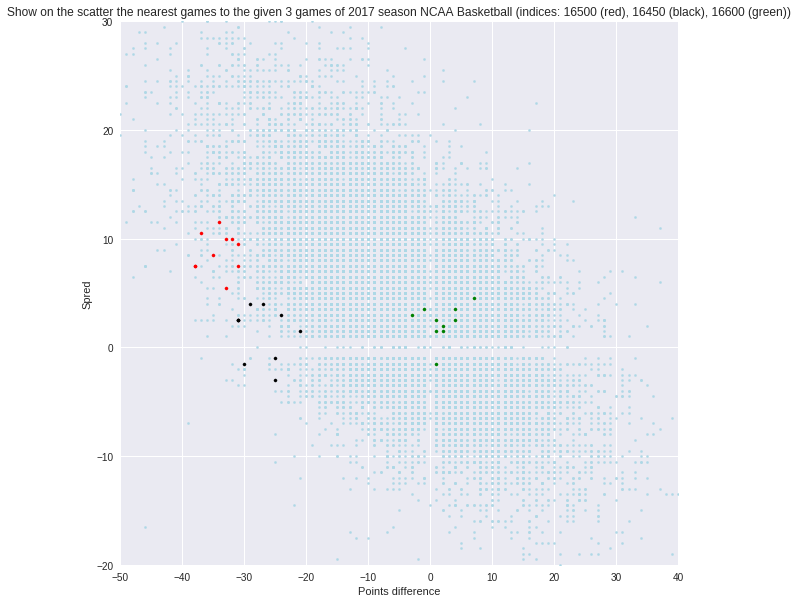

In [238]:
pl.figure(figsize=[10,10])
x = df.points_difference
y = df.spread
pl.scatter(x, y, c='lightblue', s=5, )
x1 = similar_games[16500].points_difference
y1 = similar_games[16500].spread
pl.scatter(x1, y1, c='red', s=10)
x1 = similar_games[16450].points_difference
y1 = similar_games[16450].spread
pl.scatter(x1, y1, c='black', s=10)
x1 = similar_games[16600].points_difference
y1 = similar_games[16600].spread
pl.scatter(x1, y1, c='green', s=10)
plt.xlim(-50,  40)
plt.ylim(-20, 30)
pl.xlabel('Points difference')
pl.ylabel('Spred')
pl.title('Show on the scatter the nearest games to the given 3 games of 2017 season NCAA Basketball (indices: 16500 (red), 16450 (black), 16600 (green))')
pl.show()

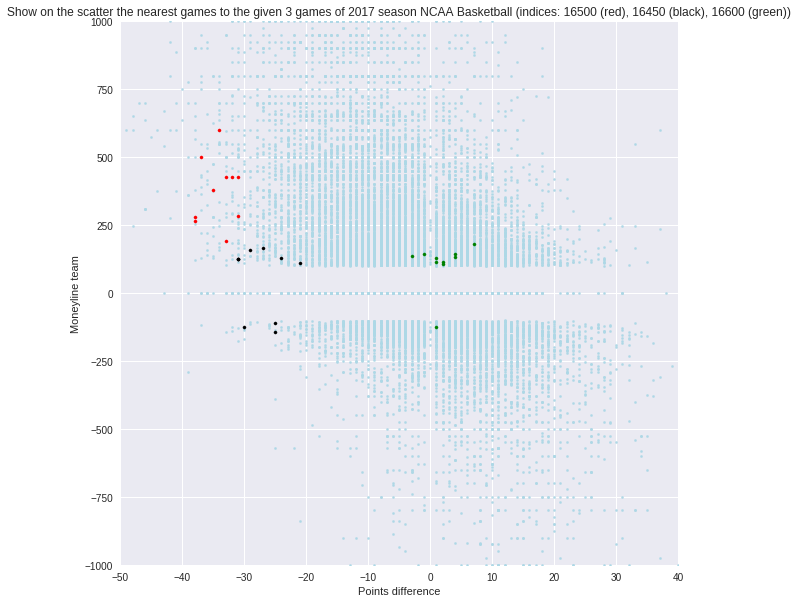

In [244]:
pl.figure(figsize=[10,10])
x = df.points_difference
y = df.moneyline_team
pl.scatter(x, y, c='lightblue', s=5, )
x1 = similar_games[16500].points_difference
y1 = similar_games[16500].moneyline_team
pl.scatter(x1, y1, c='red', s=10)
x1 = similar_games[16450].points_difference
y1 = similar_games[16450].moneyline_team
pl.scatter(x1, y1, c='black', s=10)
x1 = similar_games[16600].points_difference
y1 = similar_games[16600].moneyline_team
pl.scatter(x1, y1, c='green', s=10)
plt.xlim(-50,  40)
plt.ylim(-1000, 1000)
pl.xlabel('Points difference')
pl.ylabel('Moneyline team')
pl.title('Show on the scatter the nearest games to the given 3 games of 2017 season NCAA Basketball (indices: 16500 (red), 16450 (black), 16600 (green))')
pl.show()